In [3]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [14]:

num_imgs = 500

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
            
imgs.shape, bboxes.shape

((500, 16, 16), (500, 2, 4))

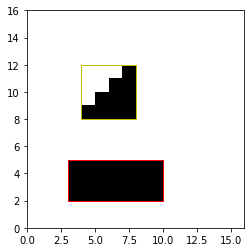

In [15]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r' if shape[0] == 0 else 'y', fc='none'))

In [5]:

X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 256), -1.2438106100631785e-16, 0.9999999999999998)

In [6]:
y = np.concatenate([bboxes / img_size, shapes], axis=-1).reshape(num_imgs, -1)
y.shape

(50000, 10)

In [7]:

i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [11]:
#from keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout
#from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
#from keras.optimizers import SGD
from keras.optimizers import gradient_descent_v2 
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

In [13]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def dist(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

num_epochs_flipping = 50
num_epochs_no_flipping = 0  # has no significant effect
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))

# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs_flipping):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for sample, (pred, exp) in enumerate(zip(pred_y, flipped_train_y)):
        
        # TODO: Make this simpler.
        pred = pred.reshape(num_objects, -1)
        exp = exp.reshape(num_objects, -1)
        
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        # TODO: Try flipping array and see if results differ.
        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = dist(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with maximum iou and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 1000000#-1  # set iou of assigned bboxes to -1, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        flipped_train_y[sample] = exp[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
            
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    #print
    
# print '------------------------------------'
# print 'Training now without flipping bboxes'
# print '------------------------------------'
    
# for epoch in range(num_epochs_flipping, num_epochs_flipping + num_epochs_no_flipping):
#     print 'Epoch', epoch
#     model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
#     pred_y = model.predict(train_X)

#     # Calculate iou/dist, but don't flip.
#     for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
#         pred_bboxes = pred_bboxes.reshape(num_objects, -1)
#         exp_bboxes = exp_bboxes.reshape(num_objects, -1)        
        
#         for exp_bbox, pred_bbox in zip(exp_bboxes, pred_bboxes):
#             ious_epoch[sample, epoch] += IOU(exp_bbox, pred_bbox)
#             dists_epoch[sample, epoch] += dist(exp_bbox, pred_bbox)
#             mses_epoch[sample, epoch] += np.mean(np.square(exp_bbox - pred_bbox))
            
#         ious_epoch[sample, epoch] /= num_objects
#         dists_epoch[sample, epoch] /= num_objects 
#         mses_epoch[sample, epoch] /= num_objects 
            
# #     print 'Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.)
#     print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
#     print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
#     print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))
#     print
    
# TODO: Calculate IOU and dist for validation data during training.

Epoch 0
1250/1250 - 5s - loss: 1.6315 - val_loss: 0.7687
Flipped 50.405 % of all elements
Mean IOU: 0.003776185721748673
Mean dist: 1.0993196284075046
Mean mse: 0.751389125013288
Epoch 1
1250/1250 - 4s - loss: 1.2563 - val_loss: 0.5534
Flipped 13.3425 % of all elements
Mean IOU: 0.008002295576847772
Mean dist: 0.8840047247832205
Mean mse: 0.5134593108063564
Epoch 2
1250/1250 - 4s - loss: 1.0709 - val_loss: 0.4491
Flipped 10.92 % of all elements
Mean IOU: 0.012029266235961617
Mean dist: 0.7704705531136297
Mean mse: 0.4011569900152676
Epoch 3
1250/1250 - 4s - loss: 0.9660 - val_loss: 0.3910
Flipped 7.430000000000001 % of all elements
Mean IOU: 0.015655954664940755
Mean dist: 0.7041381847053831
Mean mse: 0.34019957548762847
Epoch 4
1250/1250 - 4s - loss: 0.8869 - val_loss: 0.3525
Flipped 5.1450000000000005 % of all elements
Mean IOU: 0.018586419928385795
Mean dist: 0.6581054140419574
Mean mse: 0.30028421214830164
Epoch 5
1250/1250 - 4s - loss: 0.8232 - val_loss: 0.3236
Flipped 3.842500000

Flipped 1.1525 % of all elements
Mean IOU: 0.10417416640858082
Mean dist: 0.2848219737176283
Mean mse: 0.05177536125708166
Epoch 45
1250/1250 - 4s - loss: 0.1615 - val_loss: 0.0995
Flipped 1.17 % of all elements
Mean IOU: 0.1059115077699882
Mean dist: 0.28229673560563945
Mean mse: 0.050687137313184145
Epoch 46
1250/1250 - 4s - loss: 0.1588 - val_loss: 0.0983
Flipped 1.0825 % of all elements
Mean IOU: 0.10746478929930688
Mean dist: 0.27986997027968674
Mean mse: 0.04965920820634285
Epoch 47
1250/1250 - 4s - loss: 0.1545 - val_loss: 0.0972
Flipped 1.115 % of all elements
Mean IOU: 0.10920738023864761
Mean dist: 0.27747319870932363
Mean mse: 0.0486614950979656
Epoch 48
1250/1250 - 4s - loss: 0.1519 - val_loss: 0.0961
Flipped 0.9400000000000001 % of all elements
Mean IOU: 0.111167274345638
Mean dist: 0.2750753403062101
Mean mse: 0.047700926124622095
Epoch 49
1250/1250 - 4s - loss: 0.1485 - val_loss: 0.0951
Flipped 1.0025 % of all elements
Mean IOU: 0.11287723628538227
Mean dist: 0.272974220